# Projet télédétection
Audrey Zimmer

## 1. Import des librairies

In [25]:
# Librairies python
import sys
sys.path.append('..')
import os
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
from osgeo import ogr
from osgeo import gdal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, KFold


# Librairies personnelles
from libsigma import classification as cla
from libsigma import read_and_write as rw
from libsigma import plots


## Création des dossiers

In [15]:
# Chemin de base (absolu)
my_folder = "/home/onyxia/work/Projet_teledetection"

# Chemins des dossiers à créer (absolus)
results_path = os.path.join(my_folder, "../results")
figure_path = os.path.join(my_folder, "../results/figure")
img_path = os.path.join(my_folder, "img")

# Création des dossiers
os.makedirs(results_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)
os.makedirs(img_path, exist_ok=True)

print("Dossiers results, figure et img créés avec succès !")


Dossiers results, figure et img créés avec succès !


## Formatage des données

In [3]:
# Liste des bandes
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Dictionnaire pour stocker les datasets
datasets = {}

# Vérification des dimensions
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)
    print(f"Bande {bande}:")
    print(f"  - Colonnes: {datasets[bande].RasterXSize}")
    print(f"  - Lignes: {datasets[bande].RasterYSize}")
    print(f"  - Nombre de bandes: {datasets[bande].RasterCount}\n")


Bande B02:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B03:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B04:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B05:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B06:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B07:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B08:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B8A:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B11:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5

Bande B12:
  - Colonnes: 1533
  - Lignes: 612
  - Nombre de bandes: 5



/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Toutes les bandes obtenues ont la même dimension : 
- 1533 colonnes
- 612 lignes
- 5 bandes

In [4]:
# Liste des bandes
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Liste des dates 
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Dictionnaire pour stocker les datasets
datasets = {}

# Chargement des datasets
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)

# Dimensions spatiales
cols = datasets['B02'].RasterXSize
rows = datasets['B02'].RasterYSize

# Pour chaque date (indexé de 1 à 5)
for date_idx in range(1, len(dates) + 1):
    date = dates[date_idx - 1]  # Récupère la date correspondante
    # Tableau 3D pour stocker toutes les bandes pour cette date
    cube_date = np.zeros((rows, cols, len(bandes)), dtype=np.float32)

    # Pour chaque bande
    for i, bande in enumerate(bandes):
        # Lecture de la bande pour cette date
        data = datasets[bande].GetRasterBand(date_idx).ReadAsArray()
        cube_date[:, :, i] = data

    # Création du fichier de sortie (avec la date dans le nom)
    driver = gdal.GetDriverByName('GTiff')
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}.tif'
    out_dataset = driver.Create(chemin_sortie, cols, rows, len(bandes), gdal.GDT_Float32)

    # Copie des informations géoréférencées
    out_dataset.SetGeoTransform(datasets['B02'].GetGeoTransform())
    out_dataset.SetProjection(datasets['B02'].GetProjection())

    # Écriture des bandes
    for i in range(len(bandes)):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.WriteArray(cube_date[:, :, i])
        out_band.FlushCache()

    print(f"Image pour la date {date} créée : {chemin_sortie}")

Image pour la date 2024-07-19 créée : /home/onyxia/work/results/bretagne_2024-07-19.tif
Image pour la date 2024-06-07 créée : /home/onyxia/work/results/bretagne_2024-06-07.tif
Image pour la date 2024-04-18 créée : /home/onyxia/work/results/bretagne_2024-04-18.tif
Image pour la date 2024-01-19 créée : /home/onyxia/work/results/bretagne_2024-01-19.tif
Image pour la date 2023-10-08 créée : /home/onyxia/work/results/bretagne_2023-10-08.tif


In [5]:
# Test résolution problème :

# Liste des bandes
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Liste des dates
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Dictionnaire pour stocker les datasets
datasets = {}

# Chargement des datasets
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)
    if datasets[bande] is None:
        print(f"Erreur: Impossible de charger {chemin}")

# Dimensions spatiales
cols = datasets['B02'].RasterXSize
rows = datasets['B02'].RasterYSize

# Pour chaque date (indexé de 1 à 5)
for date_idx in range(1, len(dates) + 1):
    date = dates[date_idx - 1]  # Récupère la date correspondante
    # Tableau 3D pour stocker toutes les bandes pour cette date
    cube_date = np.zeros((rows, cols, len(bandes)), dtype=np.float32)

    # Pour chaque bande
    for i, bande in enumerate(bandes):
        # Lecture de la bande pour cette date
        data = datasets[bande].GetRasterBand(date_idx).ReadAsArray()
        if np.all(data == 0):
            print(f"Avertissement: La bande {bande} pour la date {date} contient uniquement des zéros.")
        cube_date[:, :, i] = data

    # Création du fichier de sortie (avec la date dans le nom)
    driver = gdal.GetDriverByName('GTiff')
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}.tif'
    out_dataset = driver.Create(chemin_sortie, cols, rows, len(bandes), gdal.GDT_Float32)

    # Copie des informations géoréférencées
    out_dataset.SetGeoTransform(datasets['B02'].GetGeoTransform())
    out_dataset.SetProjection(datasets['B02'].GetProjection())

    # Écriture des bandes
    for i in range(len(bandes)):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.WriteArray(cube_date[:, :, i])
        out_band.FlushCache()

    print(f"Image pour la date {date} créée : {chemin_sortie}")


Image pour la date 2024-07-19 créée : /home/onyxia/work/results/bretagne_2024-07-19.tif
Image pour la date 2024-06-07 créée : /home/onyxia/work/results/bretagne_2024-06-07.tif
Image pour la date 2024-04-18 créée : /home/onyxia/work/results/bretagne_2024-04-18.tif
Image pour la date 2024-01-19 créée : /home/onyxia/work/results/bretagne_2024-01-19.tif
Image pour la date 2023-10-08 créée : /home/onyxia/work/results/bretagne_2023-10-08.tif


In [9]:
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    dataset = gdal.Open(chemin)
    print(f"Métadonnées pour {bande}: {dataset.GetMetadata()}")
    for band_num in range(1, dataset.RasterCount + 1):
        band = dataset.GetRasterBand(band_num)
        print(f"Bande {band_num}: Min={band.GetMinimum()}, Max={band.GetMaximum()}")


Métadonnées pour B02: {'resolution': '10', 'spec': 'RasterSpec(epsg=32630, bounds=(399960, 5290200, 509760, 5400000), resolutions_xy=(10, 10))', 'AREA_OR_POINT': 'Area'}
Bande 1: Min=None, Max=None
Bande 2: Min=None, Max=None
Bande 3: Min=None, Max=None
Bande 4: Min=None, Max=None
Bande 5: Min=None, Max=None
Métadonnées pour B03: {'resolution': '10', 'spec': 'RasterSpec(epsg=32630, bounds=(399960, 5290200, 509760, 5400000), resolutions_xy=(10, 10))', 'AREA_OR_POINT': 'Area'}
Bande 1: Min=None, Max=None
Bande 2: Min=None, Max=None
Bande 3: Min=None, Max=None
Bande 4: Min=None, Max=None
Bande 5: Min=None, Max=None
Métadonnées pour B04: {'resolution': '10', 'spec': 'RasterSpec(epsg=32630, bounds=(399960, 5290200, 509760, 5400000), resolutions_xy=(10, 10))', 'AREA_OR_POINT': 'Area'}
Bande 1: Min=None, Max=None
Bande 2: Min=None, Max=None
Bande 3: Min=None, Max=None
Bande 4: Min=None, Max=None
Bande 5: Min=None, Max=None
Métadonnées pour B05: {'resolution': '10', 'spec': 'RasterSpec(epsg=32

In [6]:
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    dataset = gdal.Open(chemin)
    for band_num in range(1, dataset.RasterCount + 1):
        band = dataset.GetRasterBand(band_num)
        data = band.ReadAsArray()
        if data is not None:
            print(f"Quelques valeurs de la bande {bande} {band_num}: {data[0, :10]}")  # Affiche les 10 premières valeurs de la première ligne
        else:
            print(f"Bande {bande} {band_num}: Aucune donnée")


Quelques valeurs de la bande B02 1: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B02 2: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B02 3: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B02 4: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B02 5: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B03 1: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B03 2: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B03 3: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B03 4: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B03 5: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B04 1: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B04 2: [nan nan nan nan nan nan nan nan nan nan]
Quelques valeurs de la bande B04 3: [nan nan nan nan nan nan nan

## Analyse des échantillons
### Nombre d'échantillons

In [50]:
# Chemin vers le fichier shapefile
shp_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'

# Charger le fichier
gdf = gpd.read_file(shp_path)

# Compter le nombre de polygones par classe
polygon_counts = gdf['strate'].value_counts().reset_index()
polygon_counts.columns = ['Classe', 'Nombre de polygones']

# Convertir 'Classe' en chaîne de caractères pour éviter les conflits de type
polygon_counts['Classe'] = polygon_counts['Classe'].astype(str)

# Créer un DataFrame avec toutes les classes (1, 2, 3, 4), même si elles sont absentes
all_classes = pd.DataFrame({'Classe': ['1', '2', '3', '4']})

# Fusionner avec les comptes réels
polygon_counts = all_classes.merge(polygon_counts, on='Classe', how='left').fillna(0)

# Dictionnaire de correspondance classe/couleur (personnalisable)
color_map = {
    '1': '#F5DEB3',  # Sol nu (tan)
    '2': '#98FB98',  # Herbe (palegreen)
    '3': '#32CD32',  # Landes (limegreen)
    '4': '#228B22'   # Arbre (darkgreen)
}

# Créer le diagramme avec Plotly
fig_polygons = px.bar(
    polygon_counts,
    x='Classe',
    y='Nombre de polygones',
    color='Classe',
    color_discrete_map=color_map,
    title='Nombre de polygones par classe',
    labels={'Classe': 'Classe', 'Nombre de polygones': 'Nombre de polygones'},
    category_orders={'Classe': ['1', '2', '3', '4']}
)

# Personnaliser l'affichage des classes sur l'axe x
fig_polygons.update_xaxes(
    type='category',  # Forcer l'affichage en catégories discrètes
    tickvals=['1', '2', '3', '4'],  # Valeurs exactes à afficher
    ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre']   # Libellés à afficher
)

# Enregistrer la figure
output_polygon_path = '/home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.html'
os.makedirs(os.path.dirname(output_polygon_path), exist_ok=True)
fig_polygons.write_html(output_polygon_path)

# Afficher la figure dans le notebook
fig_polygons.show()


La classe 1 (sol nu) est absente des 

### Nombre de pixels par classe

In [51]:
# Charger le shapefile
gdf = gpd.read_file('/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp')

# Vérifier les valeurs uniques de 'strate'
print("Valeurs uniques de 'strate' :", gdf['strate'].unique())

# Vérifier le nombre de polygones par classe
print("Nombre de polygones par classe :\n", gdf['strate'].value_counts())


Valeurs uniques de 'strate' : [3 2 4]
Nombre de polygones par classe :
 strate
3    121
2     86
4     71
Name: count, dtype: int64


In [27]:
# Rasterisation
# Chemins des fichiers
in_vector = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
out_image = '/home/onyxia/work/results/PI_strates_bretagne_32630_raster.tif'

# Étendue des polygones
xmin, ymin, xmax, ymax = 433831.49870281, 5362866.42545753, 446289.95490494, 5367061.39833999

# Résolution spatiale (10 mètres pour Sentinel-2)
resolution = 10

# Champ contenant les labels des classes
field_name = 'strate'

# Commande pour rasteriser
cmd = (
    f"gdal_rasterize -a {field_name} "
    f"-tr {resolution} {resolution} "
    f"-te {xmin} {ymin} {xmax} {ymax} "
    "-ot Byte -of GTiff -init 0 "
    f"{in_vector} {out_image}"
)

print(f"Commande exécutée : {cmd}")
os.system(cmd)


Commande exécutée : gdal_rasterize -a strate -tr 10 10 -te 433831.49870281 5362866.42545753 446289.95490494 5367061.39833999 -ot Byte -of GTiff -init 0 /home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp /home/onyxia/work/results/PI_strates_bretagne_32630_raster.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [28]:
# Vérification des valeurs présentes dans le raster
# Lire le raster rasterisé
raster_ds = gdal.Open(out_image)
band = raster_ds.GetRasterBand(1)
raster_array = band.ReadAsArray()

# Afficher les valeurs uniques et leurs comptes
unique, counts = np.unique(raster_array, return_counts=True)
print("Valeurs uniques dans le raster :", dict(zip(unique, counts)))


Valeurs uniques dans le raster : {np.uint8(0): np.int64(518226), np.uint8(2): np.int64(1044), np.uint8(3): np.int64(1575), np.uint8(4): np.int64(1229)}


In [31]:
# Compter les pixels par classe
unique, counts = np.unique(raster_array, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Exclure la classe 0 (fond)
pixel_counts.pop(0, None)

# Créer un DataFrame avec toutes les classes (1, 2, 3, 4)
all_classes = pd.DataFrame({'Classe': [1, 2, 3, 4]})

# Fusionner avec les comptes de pixels
pixel_df = pd.merge(
    all_classes,
    pd.DataFrame({'Classe': list(pixel_counts.keys()), 'Nombre de pixels': list(pixel_counts.values())}),
    on='Classe',
    how='left'
).fillna(0)

# Dictionnaire de couleurs
color_map = {
    1: '#F5DEB3',  # Sol nu
    2: '#98FB98',  # Herbe
    3: '#32CD32',  # Landes
    4: '#228B22'   # Arbre
}

# Créer le diagramme
fig_pixels = px.bar(
    pixel_df,
    x='Classe',
    y='Nombre de pixels',
    color='Classe',
    color_discrete_map=color_map,
    title='Nombre de pixels par classe',
    labels={'Classe': 'Classe', 'Nombre de pixels': 'Nombre de pixels'},
    category_orders={'Classe': [1, 2, 3, 4]}
)

# Personnaliser l'axe x
fig_pixels.update_xaxes(
    type='category',
    tickvals=[1, 2, 3, 4],
    ticktext=['1', '2', '3', '4']
)

# Enregistrer la figure
output_pixel_path = '/home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.html'
os.makedirs(os.path.dirname(output_pixel_path), exist_ok=True)
fig_pixels.write_html(output_pixel_path)

# Afficher la figure
fig_pixels.show()


In [34]:
import plotly.graph_objects as go

# Créer le diagramme en utilisant plotly.graph_objects
fig_pixels = go.Figure()

# Ajouter les barres avec les couleurs exactes
for classe in pixel_df['Classe']:
    count = pixel_df[pixel_df['Classe'] == classe]['Nombre de pixels'].values[0]
    fig_pixels.add_trace(go.Bar(
        x=[classe],
        y=[count],
        marker_color=color_map[classe],
        name=str(classe)
    ))

# Mettre à jour la mise en page
fig_pixels.update_layout(
    title='Nombre de pixels par classe',
    xaxis_title='Classe',
    yaxis_title='Nombre de pixels',
    xaxis=dict(
        tickvals=[1, 2, 3, 4],
        ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre'],
        type='category'
    ),
    showlegend=False
)

# Afficher la figure
fig_pixels.show()

# Enregistrer la figure
output_pixel_path = '/home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.html'
os.makedirs(os.path.dirname(output_pixel_path), exist_ok=True)
fig_pixels.write_html(output_pixel_path)


## Phénologie des strates, mise en évidence des landes

In [52]:


# Chemins des fichiers d'entrée et de sortie
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
output_file = os.path.join(output_folder, 'ARI_serie_temp.tif')

# Liste des dates (adapte selon tes fichiers)
#dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Lire les dimensions et la projection depuis une image de référence
ref_image_path = os.path.join(input_folder, 'bretagne_2023-10-08.tif')
ref_ds = gdal.Open(ref_image_path)
cols = ref_ds.RasterXSize
rows = ref_ds.RasterYSize
transform = ref_ds.GetGeoTransform()
projection = ref_ds.GetProjection()

# Créer un fichier de sortie pour ARI
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

# Définir la valeur NoData
for band in range(1, len(dates) + 1):
    out_band = out_ds.GetRasterBand(band)
    out_band.SetNoDataValue(-9999)

# Calculer ARI pour chaque date
for i, date in enumerate(dates):
    # Chemins des bandes B03 et B05
    b03_path = os.path.join(input_folder, f'bretagne_{date}.tif')
    b05_path = os.path.join(input_folder, f'bretagne_{date}.tif')

    # Ouvrir les bandes B03 et B05
    b03_ds = gdal.Open(b03_path)
    b05_ds = gdal.Open(b05_path)

    # Lire les bandes 3 et 5 (adapte les indices selon ton organisation)
    b03_band = b03_ds.GetRasterBand(3)  # Supposons que B03 est la bande 3
    b05_band = b05_ds.GetRasterBand(5)  # Supposons que B05 est la bande 5

    # Lire les données
    b03 = b03_band.ReadAsArray().astype(np.float32)
    b05 = b05_band.ReadAsArray().astype(np.float32)

    # Éviter les divisions par zéro en ajoutant un epsilon
    epsilon = 1e-10
    ari = np.where((b03 == 0) | (b05 == 0), np.nan, (1/(b03 + epsilon) - 1/(b05 + epsilon)) / (1/(b03 + epsilon) + 1/(b05 + epsilon)))

    # Remplacer les NaN par la valeur NoData (-9999)
    ari = np.where(np.isnan(ari), -9999, ari)

    # Écrire ARI dans la bande de sortie
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(ari)
    out_band.FlushCache()

# Fermer les fichiers
out_ds = None

print(f"Fichier ARI_serie_temp.tif enregistré avec succès dans {output_folder}")


Fichier ARI_serie_temp.tif enregistré avec succès dans /home/onyxia/work/results/


In [2]:


# Chemin des fichiers pour la date problématique
b03_path = '/home/onyxia/work/results/bretagne_2023-10-08.tif'
b05_path = '/home/onyxia/work/results/bretagne_2023-10-08.tif'

# Ouvrir les bandes B03 et B05
b03_ds = gdal.Open(b03_path)
b05_ds = gdal.Open(b05_path)

# Lire les bandes 3 et 5
b03_band = b03_ds.GetRasterBand(3)  # Supposons que B03 est la bande 3
b05_band = b05_ds.GetRasterBand(5)  # Supposons que B05 est la bande 5

# Lire les données
b03 = b03_band.ReadAsArray().astype(np.float32)
b05 = b05_band.ReadAsArray().astype(np.float32)

# Afficher les statistiques des bandes
print("B03 - Min:", np.nanmin(b03), "Max:", np.nanmax(b03), "Moyenne:", np.nanmean(b03))
print("B05 - Min:", np.nanmin(b05), "Max:", np.nanmax(b05), "Moyenne:", np.nanmean(b05))

# Compter les valeurs nulles ou proches de zéro
print("Nombre de valeurs nulles ou proches de zéro dans B03:", np.sum(b03 <= 0.0001))
print("Nombre de valeurs nulles ou proches de zéro dans B05:", np.sum(b05 <= 0.0001))


B03 - Min: -9999.0 Max: 5564.0 Moyenne: -822.4384
B05 - Min: -9999.0 Max: 6909.0 Moyenne: 1210.6265
Nombre de valeurs nulles ou proches de zéro dans B03: 188156
Nombre de valeurs nulles ou proches de zéro dans B05: 188156


In [54]:
# Afficher les métadonnées du fichier
print("Métadonnées de B03 :", b03_ds.GetMetadata())
print("Métadonnées de B05 :", b05_ds.GetMetadata())


Métadonnées de B03 : {'AREA_OR_POINT': 'Area'}
Métadonnées de B05 : {'AREA_OR_POINT': 'Area'}


# Vérif

In [6]:
from osgeo import gdal
import numpy as np

# Liste des bandes
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Dictionnaire pour stocker les datasets
datasets = {}

# Chargement des datasets
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)
    if datasets[bande] is None:
        print(f"Erreur: Impossible de charger {chemin}")

# Index de la date 2023-10-08
date_idx = 5

# Dimensions spatiales
cols = datasets['B02'].RasterXSize
rows = datasets['B02'].RasterYSize

# Tableau 3D pour stocker toutes les bandes pour la date 2023-10-08
cube_date = np.zeros((rows, cols, len(bandes)), dtype=np.int16)

# Pour chaque bande
for i, bande in enumerate(bandes):
    data = datasets[bande].GetRasterBand(date_idx).ReadAsArray()
    data_filled = np.where(np.isnan(data), -9999, data)  # Remplacer les NaN par -9999
    cube_date[:, :, i] = data_filled.astype(np.int16)

# Création du fichier de sortie
driver = gdal.GetDriverByName('GTiff')
chemin_sortie = '/home/onyxia/work/results/bretagne_2023-10-08_fixed_correct.tif'
out_dataset = driver.Create(chemin_sortie, cols, rows, len(bandes), gdal.GDT_Int16)

# Copie des informations géoréférencées
out_dataset.SetGeoTransform(datasets['B02'].GetGeoTransform())
out_dataset.SetProjection(datasets['B02'].GetProjection())

# Définir la valeur NoData
for band_num in range(1, len(bandes) + 1):
    out_band = out_dataset.GetRasterBand(band_num)
    out_band.SetNoDataValue(-9999)

# Écriture des bandes
for i in range(len(bandes)):
    out_band = out_dataset.GetRasterBand(i + 1)
    out_band.WriteArray(cube_date[:, :, i])

# Fermeture du fichier
out_dataset = None

print(f"Image pour la date 2023-10-08 créée : {chemin_sortie}")

# Vérification du fichier de sortie
out_ds = gdal.Open(chemin_sortie)
for band_num in range(1, out_ds.RasterCount + 1):
    band = out_ds.GetRasterBand(band_num)
    data = band.ReadAsArray()
    unique_values = np.unique(data[data != -9999])  # Exclure la valeur NoData
    print(f"Fichier 2023-10-08 - Bande {band_num} - Valeurs uniques (sans NoData): {unique_values}")


Image pour la date 2023-10-08 créée : /home/onyxia/work/results/bretagne_2023-10-08_fixed_correct.tif
Fichier 2023-10-08 - Bande 1 - Valeurs uniques (sans NoData): [1098 1102 1103 ... 5032 5252 5816]
Fichier 2023-10-08 - Bande 2 - Valeurs uniques (sans NoData): [1092 1094 1095 ... 5152 5156 5628]
Fichier 2023-10-08 - Bande 3 - Valeurs uniques (sans NoData): [1067 1070 1072 ... 5236 5248 5564]
Fichier 2023-10-08 - Bande 4 - Valeurs uniques (sans NoData): [1102 1105 1119 ... 4890 4988 5209]
Fichier 2023-10-08 - Bande 5 - Valeurs uniques (sans NoData): [1034 1038 1072 ... 6711 6890 6909]
Fichier 2023-10-08 - Bande 6 - Valeurs uniques (sans NoData): [1133 1138 1146 ... 7915 7959 7990]
Fichier 2023-10-08 - Bande 7 - Valeurs uniques (sans NoData): [1108 1109 1115 ... 8208 8240 8272]
Fichier 2023-10-08 - Bande 8 - Valeurs uniques (sans NoData): [1101 1127 1136 ... 8169 8179 8273]
Fichier 2023-10-08 - Bande 9 - Valeurs uniques (sans NoData): [1139 1144 1148 ... 5816 5869 6053]
Fichier 2023-10-

In [7]:
from osgeo import gdal
import numpy as np

# Liste des bandes
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Dictionnaire pour stocker les datasets
datasets = {}

# Chargement des datasets
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)
    if datasets[bande] is None:
        print(f"Erreur: Impossible de charger {chemin}")

# Index de la date 2023-10-08
date_idx = 5

# Dimensions spatiales
cols = datasets['B02'].RasterXSize
rows = datasets['B02'].RasterYSize

# Tableau 3D pour stocker toutes les bandes pour la date 2023-10-08
cube_date = np.zeros((rows, cols, len(bandes)), dtype=np.int16)

# Pour chaque bande
for i, bande in enumerate(bandes):
    data = datasets[bande].GetRasterBand(date_idx).ReadAsArray()
    data_filled = np.where(np.isnan(data), -9999, data)  # Remplacer les NaN par -9999
    cube_date[:, :, i] = data_filled.astype(np.int16)

# Création du fichier de sortie
driver = gdal.GetDriverByName('GTiff')
chemin_sortie = '/home/onyxia/work/results/bretagne_2023-10-08_fixed_correct.tif'
out_dataset = driver.Create(chemin_sortie, cols, rows, len(bandes), gdal.GDT_Int16)

# Copie des informations géoréférencées
out_dataset.SetGeoTransform(datasets['B02'].GetGeoTransform())
out_dataset.SetProjection(datasets['B02'].GetProjection())

# Définir la valeur NoData
for band_num in range(1, len(bandes) + 1):
    out_band = out_dataset.GetRasterBand(band_num)
    out_band.SetNoDataValue(-9999)

# Écriture des bandes
for i in range(len(bandes)):
    out_band = out_dataset.GetRasterBand(i + 1)
    out_band.WriteArray(cube_date[:, :, i])

# Fermeture du fichier
out_dataset = None

print(f"Image pour la date 2023-10-08 créée : {chemin_sortie}")

# Vérification du fichier de sortie
out_ds = gdal.Open(chemin_sortie)
for band_num in range(1, out_ds.RasterCount + 1):
    band = out_ds.GetRasterBand(band_num)
    data = band.ReadAsArray()
    unique_values = np.unique(data[data != -9999])  # Exclure la valeur NoData
    print(f"Fichier 2023-10-08 - Bande {band_num} - Valeurs uniques (sans NoData): {unique_values}")


Image pour la date 2023-10-08 créée : /home/onyxia/work/results/bretagne_2023-10-08_fixed_correct.tif
Fichier 2023-10-08 - Bande 1 - Valeurs uniques (sans NoData): [1098 1102 1103 ... 5032 5252 5816]
Fichier 2023-10-08 - Bande 2 - Valeurs uniques (sans NoData): [1092 1094 1095 ... 5152 5156 5628]
Fichier 2023-10-08 - Bande 3 - Valeurs uniques (sans NoData): [1067 1070 1072 ... 5236 5248 5564]
Fichier 2023-10-08 - Bande 4 - Valeurs uniques (sans NoData): [1102 1105 1119 ... 4890 4988 5209]
Fichier 2023-10-08 - Bande 5 - Valeurs uniques (sans NoData): [1034 1038 1072 ... 6711 6890 6909]
Fichier 2023-10-08 - Bande 6 - Valeurs uniques (sans NoData): [1133 1138 1146 ... 7915 7959 7990]
Fichier 2023-10-08 - Bande 7 - Valeurs uniques (sans NoData): [1108 1109 1115 ... 8208 8240 8272]
Fichier 2023-10-08 - Bande 8 - Valeurs uniques (sans NoData): [1101 1127 1136 ... 8169 8179 8273]
Fichier 2023-10-08 - Bande 9 - Valeurs uniques (sans NoData): [1139 1144 1148 ... 5816 5869 6053]
Fichier 2023-10-

In [1]:
from osgeo import gdal
import numpy as np

# Liste des bandes
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Liste des dates
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Dictionnaire pour stocker les datasets
datasets = {}

# Chargement des datasets
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)
    if datasets[bande] is None:
        print(f"Erreur: Impossible de charger {chemin}")

# Dimensions spatiales
cols = datasets['B02'].RasterXSize
rows = datasets['B02'].RasterYSize

# Pour chaque date
for date_idx in range(1, len(dates) + 1):
    date = dates[date_idx - 1]

    # Tableau 3D pour stocker toutes les bandes pour cette date
    cube_date = np.zeros((rows, cols, len(bandes)), dtype=np.int16)

    # Pour chaque bande
    for i, bande in enumerate(bandes):
        data = datasets[bande].GetRasterBand(date_idx).ReadAsArray()
        data_filled = np.where(np.isnan(data), -9999, data)  # Remplacer les NaN par -9999
        cube_date[:, :, i] = data_filled.astype(np.int16)

    # Création du fichier de sortie
    driver = gdal.GetDriverByName('GTiff')
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}.tif'
    out_dataset = driver.Create(chemin_sortie, cols, rows, len(bandes), gdal.GDT_Int16)

    # Copie des informations géoréférencées
    out_dataset.SetGeoTransform(datasets['B02'].GetGeoTransform())
    out_dataset.SetProjection(datasets['B02'].GetProjection())

    # Définir la valeur NoData pour chaque bande
    for band_num in range(1, len(bandes) + 1):
        out_band = out_dataset.GetRasterBand(band_num)
        out_band.SetNoDataValue(-9999)

    # Écriture des bandes
    for i in range(len(bandes)):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.WriteArray(cube_date[:, :, i])

    # Fermeture du fichier
    out_dataset = None

    print(f"Image pour la date {date} créée : {chemin_sortie}")


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Image pour la date 2024-07-19 créée : /home/onyxia/work/results/bretagne_2024-07-19.tif
Image pour la date 2024-06-07 créée : /home/onyxia/work/results/bretagne_2024-06-07.tif
Image pour la date 2024-04-18 créée : /home/onyxia/work/results/bretagne_2024-04-18.tif
Image pour la date 2024-01-19 créée : /home/onyxia/work/results/bretagne_2024-01-19.tif
Image pour la date 2023-10-08 créée : /home/onyxia/work/results/bretagne_2023-10-08.tif


In [10]:
from osgeo import gdal
import numpy as np

dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

for date in dates:
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    dataset = gdal.Open(chemin_sortie)
    if dataset is not None:
        print(f"Fichier: {chemin_sortie}")
        for band_num in range(1, dataset.RasterCount + 1):
            band = dataset.GetRasterBand(band_num)
            data = band.ReadAsArray()
            unique_values = np.unique(data[data != -9999])  # Exclure la valeur NoData
            print(f"  Bande {band_num} - Valeurs uniques (sans NoData): Min={np.min(unique_values)}, Max={np.max(unique_values)}")
    else:
        print(f"Erreur: Impossible de lire le fichier {chemin_sortie}")


Fichier: /home/onyxia/work/results/bretagne_2024-07-19_fixed.tif
  Bande 1 - Valeurs uniques (sans NoData): Min=1, Max=5648
  Bande 2 - Valeurs uniques (sans NoData): Min=986, Max=6136
  Bande 3 - Valeurs uniques (sans NoData): Min=983, Max=5344
  Bande 4 - Valeurs uniques (sans NoData): Min=1057, Max=5077
  Bande 5 - Valeurs uniques (sans NoData): Min=1018, Max=6880
  Bande 6 - Valeurs uniques (sans NoData): Min=995, Max=7693
  Bande 7 - Valeurs uniques (sans NoData): Min=1110, Max=8184
  Bande 8 - Valeurs uniques (sans NoData): Min=1036, Max=7859
  Bande 9 - Valeurs uniques (sans NoData): Min=1144, Max=5761
  Bande 10 - Valeurs uniques (sans NoData): Min=1070, Max=4601
Fichier: /home/onyxia/work/results/bretagne_2024-06-07_fixed.tif
  Bande 1 - Valeurs uniques (sans NoData): Min=736, Max=7592
  Bande 2 - Valeurs uniques (sans NoData): Min=879, Max=7644
  Bande 3 - Valeurs uniques (sans NoData): Min=888, Max=7612
  Bande 4 - Valeurs uniques (sans NoData): Min=966, Max=6903
  Bande 5 -

In [3]:
from osgeo import gdal
import numpy as np

# Liste des bandes
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Liste des dates
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Dictionnaire pour stocker les datasets
datasets = {}

# Chargement des datasets
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    datasets[bande] = gdal.Open(chemin, gdal.GA_ReadOnly)
    if datasets[bande] is None:
        print(f"Erreur: Impossible de charger {chemin}")

# Dimensions spatiales
cols = datasets['B02'].RasterXSize
rows = datasets['B02'].RasterYSize

# Pour chaque date
for date_idx in range(1, len(dates) + 1):
    date = dates[date_idx - 1]

    # Tableau 3D pour stocker toutes les bandes pour cette date
    cube_date = np.zeros((rows, cols, len(bandes)), dtype=np.int16)

    # Pour chaque bande
    for i, bande in enumerate(bandes):
        data = datasets[bande].GetRasterBand(date_idx).ReadAsArray()
        data_filled = np.where(np.isnan(data), -9999, data)  # Remplacer les NaN par -9999
        cube_date[:, :, i] = data_filled.astype(np.int16)

    # Création du fichier de sortie
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    driver = gdal.GetDriverByName('GTiff')
    out_dataset = driver.Create(chemin_sortie, cols, rows, len(bandes), gdal.GDT_Int16)

    # Copie des informations géoréférencées
    out_dataset.SetGeoTransform(datasets['B02'].GetGeoTransform())
    out_dataset.SetProjection(datasets['B02'].GetProjection())

    # Définir la valeur NoData pour chaque bande et écrire les données
    for i in range(len(bandes)):
        out_band = out_dataset.GetRasterBand(i + 1)
        out_band.SetNoDataValue(-9999)  # Définir la valeur NoData
        out_band.WriteArray(cube_date[:, :, i])

    # Fermeture du fichier
    out_dataset = None

    print(f"Image pour la date {date} créée : {chemin_sortie}")


Image pour la date 2024-07-19 créée : /home/onyxia/work/results/bretagne_2024-07-19_fixed.tif
Image pour la date 2024-06-07 créée : /home/onyxia/work/results/bretagne_2024-06-07_fixed.tif
Image pour la date 2024-04-18 créée : /home/onyxia/work/results/bretagne_2024-04-18_fixed.tif
Image pour la date 2024-01-19 créée : /home/onyxia/work/results/bretagne_2024-01-19_fixed.tif
Image pour la date 2023-10-08 créée : /home/onyxia/work/results/bretagne_2023-10-08_fixed.tif


In [4]:
for date in dates:
    chemin_sortie = f'/home/onyxia/work/results/bretagne_{date}_fixed.tif'
    dataset = gdal.Open(chemin_sortie)
    if dataset is not None:
        print(f"Fichier: {chemin_sortie}")
        for band_num in range(1, dataset.RasterCount + 1):
            band = dataset.GetRasterBand(band_num)
            no_data_value = band.GetNoDataValue()
            print(f"  Bande {band_num} - NoData Value: {no_data_value}")

            # Lire les données en masquant les valeurs NoData
            data = band.ReadAsArray()
            masked_data = np.ma.masked_equal(data, no_data_value)
            print(f"  Bande {band_num} - Min: {np.min(masked_data)}, Max: {np.max(masked_data)}, Moyenne: {np.mean(masked_data)}")
    else:
        print(f"Erreur: Impossible de lire le fichier {chemin_sortie}")


Fichier: /home/onyxia/work/results/bretagne_2024-07-19_fixed.tif
  Bande 1 - NoData Value: -9999.0
  Bande 1 - Min: 1, Max: 5648, Moyenne: 1274.136792704389
  Bande 2 - NoData Value: -9999.0
  Bande 2 - Min: 986, Max: 6136, Moyenne: 1516.6220414911204
  Bande 3 - NoData Value: -9999.0
  Bande 3 - Min: 983, Max: 5344, Moyenne: 1436.9411618047038
  Bande 4 - NoData Value: -9999.0
  Bande 4 - Min: 1057, Max: 5077, Moyenne: 1962.7375273318755
  Bande 5 - NoData Value: -9999.0
  Bande 5 - Min: 1018, Max: 6880, Moyenne: 3409.415148525412
  Bande 6 - NoData Value: -9999.0
  Bande 6 - Min: 995, Max: 7693, Moyenne: 3892.917755053064
  Bande 7 - NoData Value: -9999.0
  Bande 7 - Min: 1110, Max: 8184, Moyenne: 4220.729041117807
  Bande 8 - NoData Value: -9999.0
  Bande 8 - Min: 1036, Max: 7859, Moyenne: 4271.8948162764655
  Bande 9 - NoData Value: -9999.0
  Bande 9 - Min: 1144, Max: 5761, Moyenne: 3087.0559076849236
  Bande 10 - NoData Value: -9999.0
  Bande 10 - Min: 1070, Max: 4601, Moyenne: 20

In [9]:
# Calcul ARI

# Chemins des fichiers d'entrée et de sortie
input_folder = '/home/onyxia/work/results/'
output_folder = '/home/onyxia/work/results/'
output_file = os.path.join(output_folder, 'ARI_serie_temp.tif')

# Liste des dates (adapte selon tes fichiers)
#dates = ['2023-10-08', '2024-01-19', '2024-04-18', '2024-06-07', '2024-07-19']
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Lire les dimensions et la projection depuis une image de référence
ref_image_path = os.path.join(input_folder, 'bretagne_2023-10-08_fixed.tif')
ref_ds = gdal.Open(ref_image_path)
cols = ref_ds.RasterXSize
rows = ref_ds.RasterYSize
transform = ref_ds.GetGeoTransform()
projection = ref_ds.GetProjection()

# Créer un fichier de sortie pour ARI
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_file, cols, rows, len(dates), gdal.GDT_Float32)
out_ds.SetGeoTransform(transform)
out_ds.SetProjection(projection)

# Définir la valeur NoData
for band in range(1, len(dates) + 1):
    out_band = out_ds.GetRasterBand(band)
    out_band.SetNoDataValue(-9999)

# Calculer ARI pour chaque date
for i, date in enumerate(dates):
    # Chemins des bandes B03 et B05
    b03_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')
    b05_path = os.path.join(input_folder, f'bretagne_{date}_fixed.tif')

    # Ouvrir les bandes B03 et B05
    b03_ds = gdal.Open(b03_path)
    b05_ds = gdal.Open(b05_path)

    # Lire les bandes 3 et 5 (adapte les indices selon ton organisation)
    b03_band = b03_ds.GetRasterBand(3)  # Supposons que B03 est la bande 3
    b05_band = b05_ds.GetRasterBand(5)  # Supposons que B05 est la bande 5

    # Lire les données
    b03 = b03_band.ReadAsArray().astype(np.float32)
    b05 = b05_band.ReadAsArray().astype(np.float32)

    # Éviter les divisions par zéro en ajoutant un epsilon
    #epsilon = 1e-10
    #ari = np.where((b03 == 0) | (b05 == 0), np.nan, (1/(b03 + epsilon) - 1/(b05 + epsilon)) / (1/(b03 + epsilon) + 1/(b05 + epsilon)))


    ari = np.where((b03 == 0) | (b05 == 0), np.nan, (1/b03 - 1/b05) / (1/b03 + 1/b05))


    # Remplacer les NaN par la valeur NoData (-9999)
    ari = np.where(np.isnan(ari), -9999, ari)

    # Écrire ARI dans la bande de sortie
    out_band = out_ds.GetRasterBand(i + 1)
    out_band.WriteArray(ari)
    out_band.FlushCache()

# Fermer les fichiers
out_ds = None

print(f"Fichier ARI_serie_temp.tif enregistré avec succès dans {output_folder}")


Fichier ARI_serie_temp.tif enregistré avec succès dans /home/onyxia/work/results/


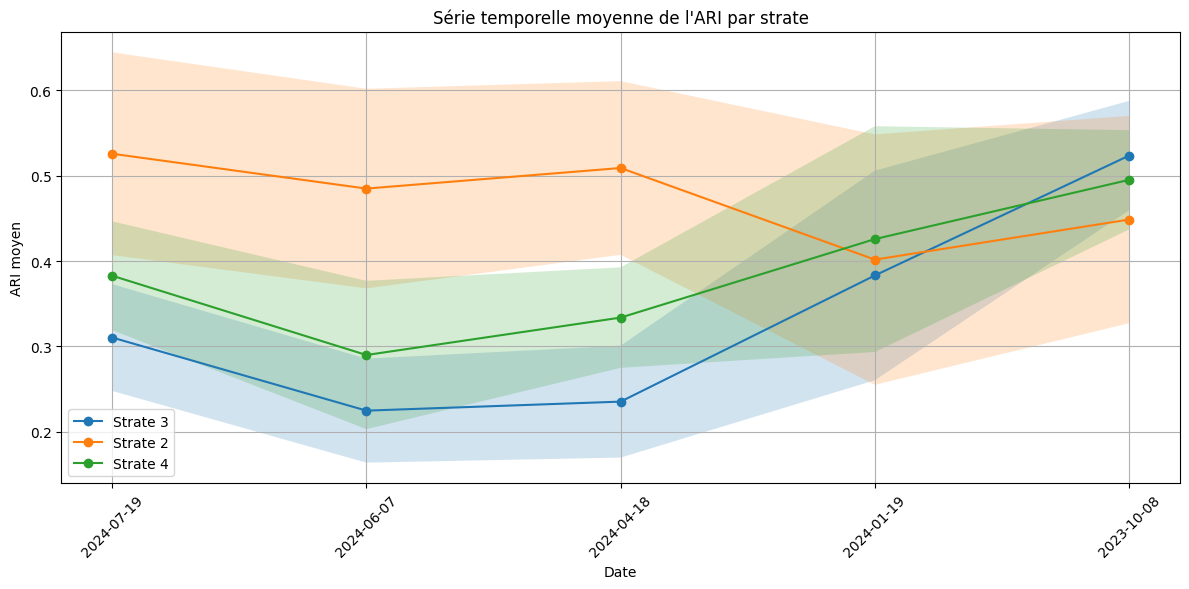

FileNotFoundError: [Errno 2] No such file or directory: 'results/figure/ARI_series.html'

In [16]:


# Charger le fichier de strates
strates_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
gdf = gpd.read_file(strates_path)

# Lire le fichier ARI_serie_temp.tif
ari_path = '/home/onyxia/work/results/ARI_serie_temp.tif'
ari_ds = gdal.Open(ari_path)
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Préparer les données pour chaque strate
strates = gdf['strate'].unique()
ari_means = {strate: [] for strate in strates}
ari_stds = {strate: [] for strate in strates}

# Obtenir les informations géométriques et spatiales
transform = ari_ds.GetGeoTransform()
projection = ari_ds.GetProjection()
x_size = ari_ds.RasterXSize
y_size = ari_ds.RasterYSize

# Pour chaque strate
for strate in strates:
    # Filtrer les polygones de la strate
    strate_gdf = gdf[gdf['strate'] == strate]

    # Pour chaque bande (date)
    for band_num in range(1, ari_ds.RasterCount + 1):
        # Lire la bande
        band = ari_ds.GetRasterBand(band_num)
        ari_array = band.ReadAsArray()

        # Créer un masque pour la strate
        rasterized = np.zeros((y_size, x_size), dtype=np.uint8)

        # Créer une couche en mémoire
        mem_drv = ogr.GetDriverByName('Memory')
        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', srs=ogr.osr.SpatialReference(wkt=projection), geom_type=ogr.wkbPolygon)

        # Ajouter chaque géométrie à la couche
        for _, row in strate_gdf.iterrows():
            feature = ogr.Feature(mem_layer.GetLayerDefn())
            feature.SetGeometry(ogr.CreateGeometryFromWkb(row.geometry.wkb))
            mem_layer.CreateFeature(feature)
            feature = None

        # Créer un raster en mémoire pour le masque
        mem_raster_ds = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, gdal.GDT_Byte)
        mem_raster_ds.SetGeoTransform(transform)
        mem_raster_ds.SetProjection(projection)
        mem_raster_band = mem_raster_ds.GetRasterBand(1)
        mem_raster_band.Fill(0)

        # Rasteriser
        gdal.RasterizeLayer(mem_raster_ds, [1], mem_layer, burn_values=[1], options=["ALL_TOUCHED=TRUE"])

        # Lire le masque rasterisé
        rasterized = mem_raster_ds.GetRasterBand(1).ReadAsArray()

        # Extraire les valeurs ARI pour la strate
        ari_values = ari_array[rasterized == 1]
        ari_values = ari_values[ari_values != -9999]  # Exclure les valeurs NoData

        # Calculer la moyenne et l'écart-type
        if len(ari_values) > 0:
            mean_ari = np.nanmean(ari_values)
            std_ari = np.nanstd(ari_values)
        else:
            mean_ari = np.nan
            std_ari = np.nan

        ari_means[strate].append(mean_ari)
        ari_stds[strate].append(std_ari)

# Afficher les séries temporelles
plt.figure(figsize=(12, 6))

# Pour chaque strate
for strate in ari_means:
    means = ari_means[strate]
    stds = ari_stds[strate]
    plt.plot(dates, means, marker='o', label=f'Strate {strate}')
    plt.fill_between(dates, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2)

# Personnaliser le graphique
plt.title('Série temporelle moyenne de l\'ARI par strate')
plt.xlabel('Date')
plt.ylabel('ARI moyen')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()

# Enregistrer la figure
# Exemple de création d'un graphique Plotly (à adapter selon ton code)
fig = px.line(x=dates, y=ari_means[strate], title='Série temporelle moyenne de l\'ARI par strate')
fig.write_html('results/figure/ARI_series.html')

In [28]:


# Charger le fichier de strates
strates_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
gdf = gpd.read_file(strates_path)

# Lire le fichier ARI_serie_temp.tif
ari_path = '/home/onyxia/work/results/ARI_serie_temp.tif'
ari_ds = gdal.Open(ari_path)
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Préparer les données pour chaque strate
strates = gdf['strate'].unique()
ari_means = {strate: [] for strate in strates}
ari_stds = {strate: [] for strate in strates}

# Obtenir les informations géométriques et spatiales
transform = ari_ds.GetGeoTransform()
projection = ari_ds.GetProjection()
x_size = ari_ds.RasterXSize
y_size = ari_ds.RasterYSize

# Pour chaque strate
for strate in strates:
    # Filtrer les polygones de la strate
    strate_gdf = gdf[gdf['strate'] == strate]

    # Pour chaque bande (date)
    for band_num in range(1, ari_ds.RasterCount + 1):
        # Lire la bande
        band = ari_ds.GetRasterBand(band_num)
        ari_array = band.ReadAsArray()

        # Créer un masque pour la strate
        rasterized = np.zeros((y_size, x_size), dtype=np.uint8)

        # Créer une couche en mémoire
        mem_drv = ogr.GetDriverByName('Memory')
        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', srs=ogr.osr.SpatialReference(wkt=projection), geom_type=ogr.wkbPolygon)

        # Ajouter chaque géométrie à la couche
        for _, row in strate_gdf.iterrows():
            feature = ogr.Feature(mem_layer.GetLayerDefn())
            feature.SetGeometry(ogr.CreateGeometryFromWkb(row.geometry.wkb))
            mem_layer.CreateFeature(feature)
            feature = None

        # Créer un raster en mémoire pour le masque
        mem_raster_ds = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, gdal.GDT_Byte)
        mem_raster_ds.SetGeoTransform(transform)
        mem_raster_ds.SetProjection(projection)
        mem_raster_band = mem_raster_ds.GetRasterBand(1)
        mem_raster_band.Fill(0)

        # Rasteriser
        gdal.RasterizeLayer(mem_raster_ds, [1], mem_layer, burn_values=[1], options=["ALL_TOUCHED=TRUE"])

        # Lire le masque rasterisé
        rasterized = mem_raster_ds.GetRasterBand(1).ReadAsArray()

        # Extraire les valeurs ARI pour la strate
        ari_values = ari_array[rasterized == 1]
        ari_values = ari_values[ari_values != -9999]  # Exclure les valeurs NoData

        # Calculer la moyenne et l'écart-type
        if len(ari_values) > 0:
            mean_ari = np.nanmean(ari_values)
            std_ari = np.nanstd(ari_values)
        else:
            mean_ari = np.nan
            std_ari = np.nan

        ari_means[strate].append(mean_ari)
        ari_stds[strate].append(std_ari)

# Créer le dossier s'il n'existe pas
os.makedirs('results/figure', exist_ok=True)

# Créer un graphique avec Plotly
fig = go.Figure()

# Pour chaque strate
for strate in ari_means:
    means = ari_means[strate]
    stds = ari_stds[strate]
    fig.add_trace(go.Scatter(
        x=dates,
        y=means,
        mode='lines+markers',
        name=f'Strate {strate}',
        error_y=dict(
            type='data',
            array=stds,
            visible=True
        )
    ))

# Personnaliser le graphique
fig.update_layout(
    title='Série temporelle moyenne de l\'ARI par strate',
    xaxis_title='Date',
    yaxis_title='ARI moyen',
    legend_title='Strates',
    hovermode='x unified'
)

# Enregistrer le graphique en HTML
fig.write_html('results/figure/ARI_series.html')

# Afficher le graphique
fig.show()


In [18]:


# Charger le fichier de strates
strates_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
gdf = gpd.read_file(strates_path)

# Lire le fichier ARI_serie_temp.tif
ari_path = '/home/onyxia/work/results/ARI_serie_temp.tif'
ari_ds = gdal.Open(ari_path)
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Préparer les données pour chaque strate
strates = gdf['strate'].unique()
ari_means = {strate: [] for strate in strates}
ari_stds = {strate: [] for strate in strates}

# Obtenir les informations géométriques et spatiales
transform = ari_ds.GetGeoTransform()
projection = ari_ds.GetProjection()
x_size = ari_ds.RasterXSize
y_size = ari_ds.RasterYSize

# Pour chaque strate
for strate in strates:
    # Filtrer les polygones de la strate
    strate_gdf = gdf[gdf['strate'] == strate]

    # Pour chaque bande (date)
    for band_num in range(1, ari_ds.RasterCount + 1):
        # Lire la bande
        band = ari_ds.GetRasterBand(band_num)
        ari_array = band.ReadAsArray()

        # Créer un masque pour la strate
        rasterized = np.zeros((y_size, x_size), dtype=np.uint8)

        # Créer une couche en mémoire
        mem_drv = ogr.GetDriverByName('Memory')
        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', srs=ogr.osr.SpatialReference(wkt=projection), geom_type=ogr.wkbPolygon)

        # Ajouter chaque géométrie à la couche
        for _, row in strate_gdf.iterrows():
            feature = ogr.Feature(mem_layer.GetLayerDefn())
            feature.SetGeometry(ogr.CreateGeometryFromWkb(row.geometry.wkb))
            mem_layer.CreateFeature(feature)
            feature = None

        # Créer un raster en mémoire pour le masque
        mem_raster_ds = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, gdal.GDT_Byte)
        mem_raster_ds.SetGeoTransform(transform)
        mem_raster_ds.SetProjection(projection)
        mem_raster_band = mem_raster_ds.GetRasterBand(1)
        mem_raster_band.Fill(0)

        # Rasteriser
        gdal.RasterizeLayer(mem_raster_ds, [1], mem_layer, burn_values=[1], options=["ALL_TOUCHED=TRUE"])

        # Lire le masque rasterisé
        rasterized = mem_raster_ds.GetRasterBand(1).ReadAsArray()

        # Extraire les valeurs ARI pour la strate
        ari_values = ari_array[rasterized == 1]
        ari_values = ari_values[ari_values != -9999]  # Exclure les valeurs NoData

        # Calculer la moyenne et l'écart-type
        if len(ari_values) > 0:
            mean_ari = np.nanmean(ari_values)
            std_ari = np.nanstd(ari_values)
        else:
            mean_ari = np.nan
            std_ari = np.nan

        ari_means[strate].append(mean_ari)
        ari_stds[strate].append(std_ari)

# Créer le dossier s'il n'existe pas
os.makedirs('results/figure', exist_ok=True)

# Préparer les données pour Plotly
plot_data = []
for strate in ari_means:
    for i, date in enumerate(dates):
        plot_data.append({
            'Date': date,
            'Strate': strate,
            'ARI moyen': ari_means[strate][i],
            'Écart-type': ari_stds[strate][i]
        })

# Créer un DataFrame pour Plotly
df = pd.DataFrame(plot_data)

# Créer le graphique avec Plotly Express
fig = px.line(df, x='Date', y='ARI moyen', color='Strate', error_y='Écart-type',
              title='Série temporelle moyenne de l\'ARI par strate',
              labels={'ARI moyen': 'ARI moyen', 'Date': 'Date'})

# Enregistrer le graphique en HTML
fig.write_html('results/figure/ARI_series.html')


In [29]:


# Charger le fichier de strates
strates_path = '/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp'
gdf = gpd.read_file(strates_path)

# Lire le fichier ARI_serie_temp.tif
ari_path = '/home/onyxia/work/results/ARI_serie_temp.tif'
ari_ds = gdal.Open(ari_path)
dates = ['2024-07-19', '2024-06-07', '2024-04-18', '2024-01-19', '2023-10-08']

# Préparer les données pour chaque strate
strates = gdf['strate'].unique()
ari_means = {strate: [] for strate in strates}
ari_stds = {strate: [] for strate in strates}

# Obtenir les informations géométriques et spatiales
transform = ari_ds.GetGeoTransform()
projection = ari_ds.GetProjection()
x_size = ari_ds.RasterXSize
y_size = ari_ds.RasterYSize

# Pour chaque strate
for strate in strates:
    # Filtrer les polygones de la strate
    strate_gdf = gdf[gdf['strate'] == strate]

    # Pour chaque bande (date)
    for band_num in range(1, ari_ds.RasterCount + 1):
        # Lire la bande
        band = ari_ds.GetRasterBand(band_num)
        ari_array = band.ReadAsArray()

        # Créer un masque pour la strate
        rasterized = np.zeros((y_size, x_size), dtype=np.uint8)

        # Créer une couche en mémoire
        mem_drv = ogr.GetDriverByName('Memory')
        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', srs=ogr.osr.SpatialReference(wkt=projection), geom_type=ogr.wkbPolygon)

        # Ajouter chaque géométrie à la couche
        for _, row in strate_gdf.iterrows():
            feature = ogr.Feature(mem_layer.GetLayerDefn())
            feature.SetGeometry(ogr.CreateGeometryFromWkb(row.geometry.wkb))
            mem_layer.CreateFeature(feature)
            feature = None

        # Créer un raster en mémoire pour le masque
        mem_raster_ds = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, gdal.GDT_Byte)
        mem_raster_ds.SetGeoTransform(transform)
        mem_raster_ds.SetProjection(projection)
        mem_raster_band = mem_raster_ds.GetRasterBand(1)
        mem_raster_band.Fill(0)

        # Rasteriser
        gdal.RasterizeLayer(mem_raster_ds, [1], mem_layer, burn_values=[1], options=["ALL_TOUCHED=TRUE"])

        # Lire le masque rasterisé
        rasterized = mem_raster_ds.GetRasterBand(1).ReadAsArray()

        # Extraire les valeurs ARI pour la strate
        ari_values = ari_array[rasterized == 1]
        ari_values = ari_values[ari_values != -9999]  # Exclure les valeurs NoData

        # Calculer la moyenne et l'écart-type
        if len(ari_values) > 0:
            mean_ari = np.nanmean(ari_values)
            std_ari = np.nanstd(ari_values)
        else:
            mean_ari = np.nan
            std_ari = np.nan

        ari_means[strate].append(mean_ari)
        ari_stds[strate].append(std_ari)

# Créer le dossier s'il n'existe pas
os.makedirs('/home/onyxia/work/results/figure', exist_ok=True)

# Créer le graphique avec Plotly
fig = go.Figure()

# Pour chaque strate
for strate in ari_means:
    means = ari_means[strate]
    stds = ari_stds[strate]

    # Ajouter la ligne de la moyenne
    fig.add_trace(go.Scatter(
        x=dates,
        y=means,
        mode='lines+markers',
        name=f'Strate {strate}'
    ))

    # Ajouter l'enveloppe de l'écart-type
    fig.add_trace(go.Scatter(
        x=np.concatenate([dates, dates[::-1]]),
        y=np.concatenate([np.array(means) + np.array(stds), (np.array(means) - np.array(stds))[::-1]]),
        fill='toself',
        fillcolor='rgba(68, 68, 68, 0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo="skip"
    ))

# Personnaliser le graphique
fig.update_layout(
    title='Série temporelle moyenne de l\'ARI par strate',
    xaxis_title='Date',
    yaxis_title='ARI moyen',
    legend_title='Strates',
    hovermode='x unified'
)

# Enregistrer le graphique en HTML
fig.write_html('/home/onyxia/work/results/figure/ARI_series.html')

# Afficher le graphique
fig.show()
